In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
class lstmimpl(object):

    def __init__(self, inputdim, outputdim, hiddendim, learning_rate, is_decoder, losses):        
        self.inputdim = inputdim
        self.hiddendim = hiddendim
        self.is_decoder = is_decoder
        self.outputdim = outputdim
        self.losses = losses

        self.hprev = np.zeros((hiddendim , 1))#previous batch hidden state stored
        self.sprev = np.zeros((hiddendim , 1))#previous batch hidden state stored


        #parameters
        self.Why = np.random.randn(outputdim, hiddendim)*0.01#[y x h]
        self.Wf = np.random.randn(hiddendim, hiddendim + inputdim)*0.01 # input to hidden
        self.Wi = np.random.randn(hiddendim, hiddendim + inputdim)*0.01 # input to hidden
        self.Wc = np.random.randn(hiddendim, hiddendim + inputdim)*0.01 # input to hidden
        self.Wo = np.random.randn(hiddendim, hiddendim + inputdim)*0.01 # input to hidden
        self.by = np.zeros((outputdim, 1))
        self.bf = np.zeros((hiddendim, 1)) # output bias
        self.bi = np.zeros((hiddendim, 1)) # output bias
        self.bc = np.zeros((hiddendim, 1)) # output bias
        self.bo = np.zeros((hiddendim, 1)) # output bias

        #the Adagrad gradient update relies upon having a memory of the sum of squares of dparams
        self.mWhy =  np.zeros_like(self.Why)
        self.mWf =  np.zeros_like(self.Wf)
        self.mWi =  np.zeros_like(self.Wi)
        self.mWc =  np.zeros_like(self.Wc)
        self.mWo =  np.zeros_like(self.Wo)
        self.mby =  np.zeros_like(self.by)
        self.mbf =  np.zeros_like(self.bf)
        self.mbi =  np.zeros_like(self.bi)
        self.mbc =  np.zeros_like(self.bc)
        self.mbo =  np.zeros_like(self.bo)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def add_loss(self, loss):
        self.losses.append(loss)

    def train(self, inputs, targets):
        xs, hs, xh, ys, ps, f, inp, cc, o, s = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
        hs[-1] = np.copy(self.hprev)
        s[-1] = np.copy(self.sprev)  

        dWhy = np.zeros_like(self.Why)
        dWf = np.zeros_like(self.Wf)
        dWi = np.zeros_like(self.Wi)
        dWo = np.zeros_like(self.Wo)
        dWc = np.zeros_like(self.Wc)
        dby = np.zeros_like(self.by)
        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbo = np.zeros_like(self.bo)
        dbc = np.zeros_like(self.bc)
        dhnext = np.zeros_like(self.hprev)
        dsnext = np.zeros_like(self.sprev)

        # Forward Propagation
        loss = 0
        for t in range(len(inputs)):            
            xs[t] = np.zeros((self.inputdim,1)) 
            # one hot encoding of word
            if(self.is_decoder):
                if(t==0):
                    xs[t][inputs[t]] = 0
                else:
                    xs[t][inputs[t]] = 1
            else:
                xs[t][inputs[t]] = 1
                
            # Concatenate x and h
            xh[t] = np.hstack((xs[t].ravel(), hs[t-1].ravel())).reshape(self.inputdim+self.hiddendim,1)
            # Forget gate equation
            f[t]  = self.sigmoid(np.dot(self.Wf, xh[t]) + self.bf)
            # Input gate layer decides which values we’ll update. 
            inp[t] = self.sigmoid(np.dot(self.Wi, xh[t]) + self.bi)
            # C~ is denoted by cc
            # Indicates new candidate values, that could be added to the state
            cc[t] = np.tanh(np.dot(self.Wc, xh[t]) + self.bc)
            # Update new state
            s[t] = f[t] * s[t-1] + inp[t] * cc[t]
            # This layer decides parts of the cell state we’re going to output
            o[t] = self.sigmoid(np.dot(self.Wo, xh[t]) + self.bo)
            # New hidden layer
            hs[t] = o[t] * np.tanh(s[t])
            # calculate cross-entropy loss
            ys[t] = np.dot(self.Why, hs[t]) + self.by
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) 
            loss += -np.log(ps[t][targets[t],0]) 

        # Backward propagation: Do gradient descent on above parameters from reverse
        for t in reversed(range(len(inputs))):
            # Back propagation for the softmax layer
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1  
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
        
            dh = np.dot(self.Why.T, dy) + dhnext
            
            # Back propagation for the output gate
            do = o[t]*(1-o[t]) *dh * np.tanh(s[t])
            dWo += np.dot(do, xh[t].T)
            dbo += do
            
            # Back propagation for cell state
            ds = dh * o[t] * (1-np.tanh(s[t])**2) + dsnext
            
            # Back propagation for input gate
            dinp = inp[t]*(1-inp[t]) * cc[t] * ds
            dWi += np.dot(dinp, xh[t].T)
            dbi += dinp
            
            # Back propagation for new candidate values
            dcc = (1-cc[t]**2) * inp[t] * ds
            dWc += np.dot(dcc, xh[t].T)
            dbc += dcc 
            
            # Back propagation for forget gate
            df = f[t]*(1-f[t]) * s[t-1] * ds
            dWf += np.dot(df, xh[t].T)
            dbf += df       
                  
            # Combining all to find hnext
            dxh = np.zeros_like(xh[t])
            dxo = np.dot(self.Wo.T, do)
            dxi = np.dot(self.Wi.T, dinp)
            dxcc = np.dot(self.Wc.T, dcc)
            dxf = np.dot(self.Wf.T, df)    
            dxh = dxo + dxi + dxcc + dxf
            
            # Update values for future state 
            dsnext = ds * f[t]
            
            # Update values for future hidden value 
            dhnext = dxh[(xh[t].shape[0]-self.hiddendim):,:]

        for dparam in [dWf, dWi, dWc,dWo,dWhy, dbf,dbi,dbc,dbo, dby]:
            np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients


        #update RNN parameters according to Adagrad
        for param, dparam, mem in zip([self.Wf, self.Wi, self.Wc, self.Wo, self.Why, self.bf, self.bi, self.bc, self.bo, self.by], 
                                [dWf, dWi, dWc,dWo,dWhy, dbf,dbi,dbc,dbo, dby], 
                                [self.mWf, self.mWi,self.mWc,self.mWo, self.mWhy,self.mbf,self.mbi,self.mbc,self.mbo, self.mby]):
            mem += dparam * dparam
            param += -self.learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update
        
        self.hprev = hs[len(inputs)-1]
        self.sprev = s[len(inputs)-1]

        return loss
    
    def getHidden(self, xin):
        h = np.zeros_like(self.hprev)
        sp = np.zeros_like(self.sprev)
        for t in range(len(xin)): 
            x = np.zeros((self.inputdim, 1))
            x[xin[t]] = 1
            xh = np.hstack((x.ravel(), h.ravel())).reshape(self.inputdim+self.hiddendim,1)
            f  = self.sigmoid(np.dot(self.Wf, xh) + self.bf)
            inp = self.sigmoid(np.dot(self.Wi, xh) + self.bi)
            cc = np.tanh(np.dot(self.Wc, xh) + self.bc)
            sp = f * sp + inp * cc
            o = self.sigmoid(np.dot(self.Wo, xh) + self.bo)
            h = o * np.tanh(sp)             
        return h, sp
        
    def translate(self, eos_index):
        h = self.hprev
        sp = self.sprev
        x = np.zeros((self.inputdim,1))
        y = np.zeros((self.inputdim,1))
        indices = []
        for ii in range(20):
            xh = np.hstack((x.ravel(), h.ravel())).reshape(self.inputdim+self.hiddendim,1)
            f  = self.sigmoid(np.dot(self.Wf, xh) + self.bf)
            inp = self.sigmoid(np.dot(self.Wi, xh) + self.bi)
            cc = np.tanh(np.dot(self.Wc, xh) + self.bc)
            sp = f * sp + inp * cc
            o = self.sigmoid(np.dot(self.Wo, xh) + self.bo)
            h = o * np.tanh(sp)
            y = np.dot(self.Why, h) + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            i = p.argmax()
            x = np.zeros((self.inputdim, 1))
            x[i] = 1
            indices.append(i)
            if(eos_index == i):
                break

        return indices

In [3]:
#read german text file
data = open('de-json.txt', 'r').read()
vocab = list(set(data.replace("\n", " <eos> ").split(" ")))
data = data.replace("\n", " <eos>\n").split("\n")
data_size, vocab_size = len(data), len(vocab)

#dictionary for encoding and decoding from 1-of-k
word_to_index = { w:i for i,w in enumerate(vocab) }

In [4]:
#read english text file
data2 = open('en-json.txt', 'r').read()
vocab2 = list(set(data2.replace("\n", " <eos> ").split(" ")))
data2 = data2.replace("\n", " <eos>\n").split("\n")
data_size2, vocab_size2 = len(data2), len(vocab2)

#dictionary for encoding and decoding from 1-of-k
word_to_index2 = { w:i for i,w in enumerate(vocab2) }
index_to_word2 = { i:w for i,w in enumerate(vocab2) }

In [3]:
def load_persisted_models(encoder_model_file_name, decoder_model_file_name):
    encoder = None
    decoder = None
    with open(encoder_model_file_name, 'rb') as handle:
	    encoder = pickle.load(handle)
    with open(decoder_model_file_name, 'rb') as handle:
        decoder = pickle.load(handle)
    print("Models loaded successfully!")
    return encoder, decoder

In [18]:
model1, model2 = load_persisted_models('models/encoder_4.model', 'models/decoder_4.model')

Models loaded successfully!


In [40]:
def test_translation(word_to_index, word_to_index2, index_to_word2, model1, model2):
    print('Testing Translate: German to English')
    test = "ich habe ein buch dexp <eos>"
    print('German: '+ test)
    testArray = test.split()
    x = [word_to_index[w] for w in testArray[:-1]]
    htest, stest = model1.getHidden(x)
    model2.hprev = htest 
    model2.sprev = stest
    eos_index = word_to_index2['<eos>'.strip()]
    oTest = model2.translate(eos_index)
    txt = ' '.join(index_to_word2[i] for i in oTest)
    print('English: {} \n'.format(txt))
    
test_translation(word_to_index, word_to_index2, index_to_word2, model1, model2)

Testing Translate: German to English
German: ich habe ein buch dexp <eos>
English: extraordinarily signed sale world chatterbox rainproof reptiles misses shoulderlength stools came chatterbox chatterbox rainproof smith driving smith solid cat originally 



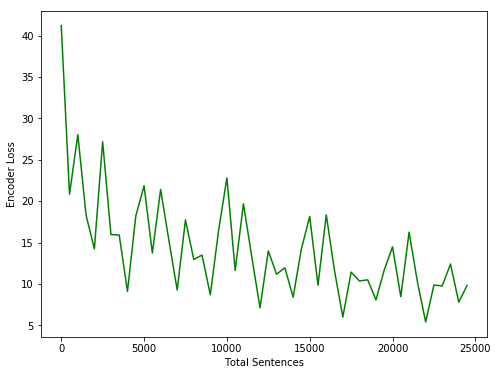

In [19]:
x_axis_list = [x*500 for x in range(len(model1.losses))]
plt.figure(figsize=(8,6))
plt.plot(x_axis_list, model1.losses, color='g')
plt.ylabel('Encoder Loss')
plt.xlabel('Total Sentences')
plt.show()

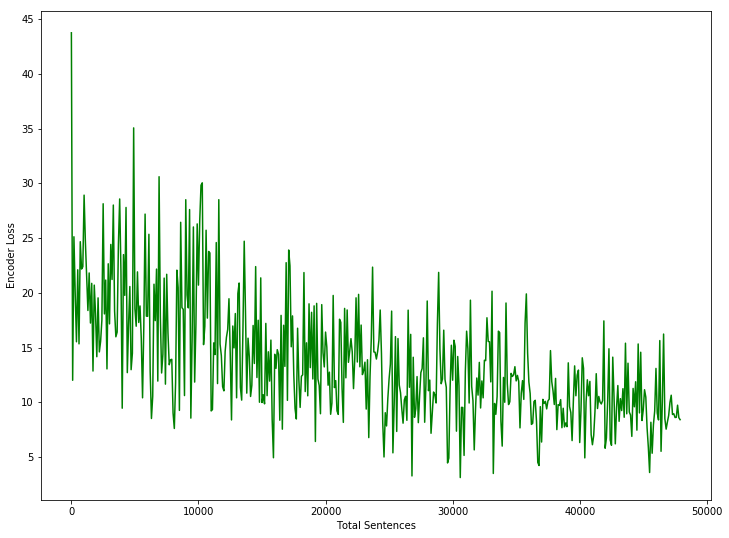

In [38]:
x_axis_list = [x*100 for x in range(len(model1.losses))]
plt.figure(figsize=(12,9))
plt.plot(x_axis_list, model1.losses, color='g')
plt.ylabel('Encoder Loss')
plt.xlabel('Total Sentences')
plt.show()

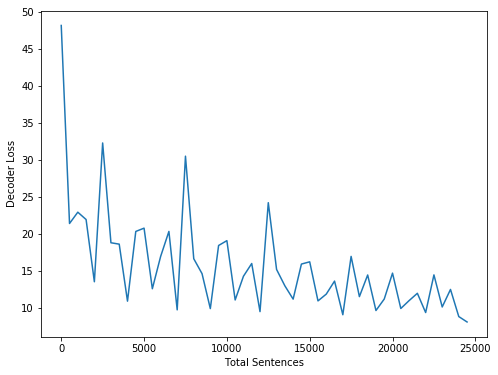

In [20]:
x_axis_list = [x*500 for x in range(len(model2.losses))]
plt.figure(figsize=(8,6))
plt.plot(x_axis_list, model2.losses)
plt.ylabel('Decoder Loss')
plt.xlabel('Total Sentences')
plt.show()

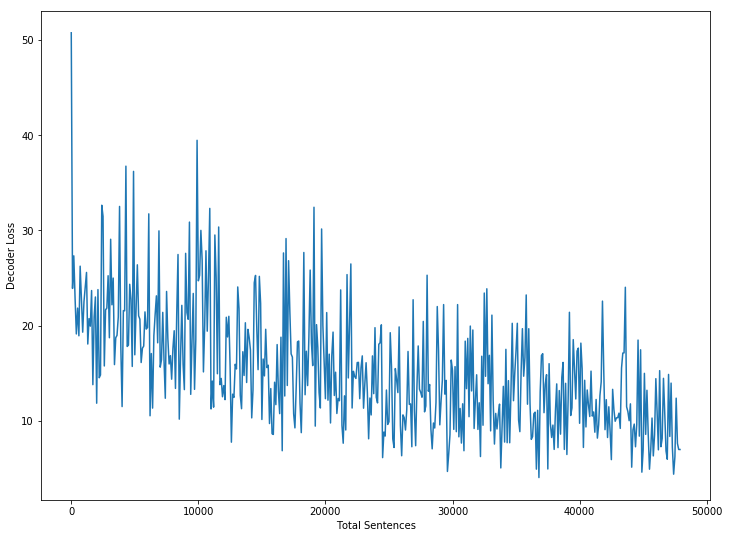

In [33]:
x_axis_list = [x*100 for x in range(len(model2.losses))]
plt.figure(figsize=(12,9))
plt.plot(x_axis_list, model2.losses)
plt.ylabel('Decoder Loss')
plt.xlabel('Total Sentences')
plt.show()

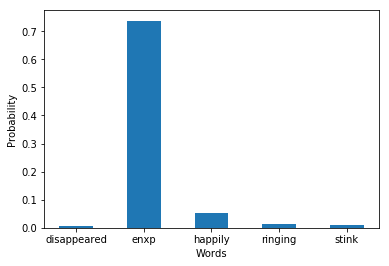

In [17]:
word_probs = {'enxp': 0.7374450827038543, 'happily': 0.05194894638814124, 'ringing': 0.013574392301203421, 'stink': 0.008251314780334173, 'disappeared': 0.006396344318954576}
plt.bar(word_probs.keys(), word_probs.values(), width=0.5)
plt.ylabel('Probability')
plt.xlabel('Words')
plt.show()

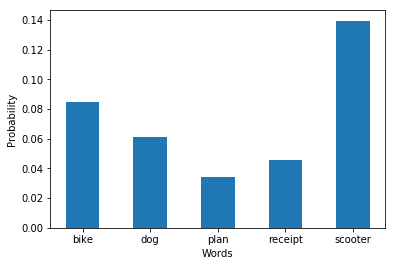

In [23]:
word_probs = {'scooter': 0.1394495284344847, 'bike': 0.08460564272642289, 'dog': 0.06092487487802991, 'receipt': 0.04544945320500837, 'plan': 0.033961512067631545}
plt.bar(word_probs.keys(), word_probs.values(), width=0.5)
plt.ylabel('Probability')
plt.xlabel('Words')
plt.show()